In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import scanpy as sc
from os.path import join
from os import listdir
import anndata

import numpy as np

import scipy


Take a large AnnData and divide into several ones of same size

In [3]:
ad_path = '/mnt/f/workspace/theislab/retina/data/integration_oct_2022/output/retina_500_cells_all_sn+sc_batch_donor_dataset_cell.type_2022/prepare/unscaled/HVG.1K/adata_pre.h5ad'
os.path.exists(ad_path)

True

In [4]:
adata = sc.read_h5ad(ad_path)

In [5]:
adata.obs['batch_donor_dataset']

Chen_a_10x3_Lobe_19_D003_Nu_AAACGAAGTGGTCCGT-1-0:Chen_a:0    nan:Chen_a:0
Chen_a_10x3_Lobe_19_D003_Nu_AAACGCTTCAGAGTGG-1-0:Chen_a:0    nan:Chen_a:0
Chen_a_10x3_Lobe_19_D003_Nu_AAAGAACTCCCTCTCC-1-0:Chen_a:0    nan:Chen_a:0
Chen_a_10x3_Lobe_19_D003_Nu_AAAGGGCAGTTCTCTT-1-0:Chen_a:0    nan:Chen_a:0
Chen_a_10x3_Lobe_19_D003_Nu_AAAGGTATCGCTAAAC-1-0:Chen_a:0    nan:Chen_a:0
                                                                 ...     
H3CD73dpS2_TTGTAGGTCGTGGACC-1-18:Sanes:18                    nan:Sanes:18
H3CD73dpS2_TTTATGCCAAGCCCAC-1-18:Sanes:18                    nan:Sanes:18
H3CD73dpS2_TTTCCTCCACTGTGTA-1-18:Sanes:18                    nan:Sanes:18
H3CD73dpS2_TTTGGTTAGAAGGACA-1-18:Sanes:18                    nan:Sanes:18
H3CD73dpS2_TTTGTCAGTAATCACC-1-18:Sanes:18                    nan:Sanes:18
Name: batch_donor_dataset, Length: 85560, dtype: category
Categories (152, object): ['nan:Chang:0', 'nan:Chang:1', 'nan:Chang:2', 'nan:Chang:3', ..., 'nan:Wong:1', 'nan:Wong:2', 'nan:Won

In [6]:
adata.obs_names.value_counts()

Chen_a_10x3_Lobe_19_D003_Nu_AAACGAAGTGGTCCGT-1-0:Chen_a:0    1
GSM3988011_CELL3954191-4:Hackney:4                           1
GSM3988011_CELL3954088-4:Hackney:4                           1
GSM3988011_CELL3953999-4:Hackney:4                           1
GSM3988011_CELL3953941-4:Hackney:4                           1
                                                            ..
Chen_b_19D013_lobe_NeuNT_AATTCCTTCCAGTACA-1-10:Chen_b:10     1
Chen_b_19D013_lobe_NeuNT_AATGGCTGTTGACGGA-1-10:Chen_b:10     1
Chen_b_19D013_lobe_NeuNT_AATGGCTAGGCTTCCG-1-10:Chen_b:10     1
Chen_b_19D013_lobe_NeuNT_AATGGCTAGGAACTCG-1-10:Chen_b:10     1
H3CD73dpS2_TTTGTCAGTAATCACC-1-18:Sanes:18                    1
Length: 85560, dtype: int64

In [7]:

import scipy as sp
from scIB.utils import *
import os
import anndata

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
from scipy.sparse import issparse

In [8]:
hvg=None
n_epochs=5
n_layers=2
n_hidden=128
n_latent=30

In [9]:
batch = 'batch_donor_dataset'

In [10]:
checkSanity(adata, batch, hvg)

In [11]:
# Check for counts data layer
if 'counts' not in adata.layers:
    raise TypeError('Adata does not contain a `counts` layer in `adata.layers[`counts`]`')

from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from sklearn.preprocessing import LabelEncoder
from scvi.dataset import AnnDatasetFromAnnData

In [59]:

import pandas as pd

In [118]:
def make_sample(adata, net_adata, start, end):
    # adata.obs_names[adata.obs_names.isin(obs_names)]
    # obs_names_mask = pd.Series(adata.obs_names).sample(sample_size)
    # obs_names = adata.obs_names[adata.obs_names.isin(obs_names_mask)]
    obs_names = adata.obs_names[start: end]
    # print(obs_names)
    adata_sample = adata[obs_names].copy()
    net_adata_sample = AnnDatasetFromAnnData(net_adata[obs_names].copy())
    return adata_sample, net_adata_sample


# Defaults from SCVI github tutorials scanpy_pbmc3k and harmonization

if n_epochs is None:
    n_epochs=np.min([round((20000/adata.n_obs)*400), 400])


print('# layers', n_layers)
print('# n_hidden', n_hidden)
print('# n_latent', n_latent)
print('# of epochs (estimated or user): %i' % n_epochs)

net_adata = adata.copy()
net_adata.X = adata.layers['counts']
del net_adata.layers['counts']
# Ensure that the raw counts are not accidentally used
del net_adata.raw # Note that this only works from anndata 0.7
# Define batch indices
le = LabelEncoder()
net_adata.obs['batch_indices'] = le.fit_transform(net_adata.obs[batch].values)

# a sample to test the per sample training
adata_sample, net_adata_sample = make_sample(adata, net_adata, 0, 100)

net_adataset = AnnDatasetFromAnnData(net_adata)



# layers 2
# n_hidden 128
# n_latent 30
# of epochs (estimated or user): 5
[2023-05-24 00:39:19,455] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 00:39:19,462] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 00:39:19,463] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 00:39:19,466] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 00:39:19,467] INFO - scvi.dataset.dataset | Downsampled from 100 to 100 cells
[2023-05-24 00:39:19,469] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 00:39:19,919] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 00:39:19,923] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 00:39:21,108] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 00:39:21,300] INFO - scvi.dataset.dataset |

In [112]:
trainer.train(n_epochs=n_epochs, lr=1e-3)

[2023-05-24 00:37:35,572] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 00:37:35,574] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.65it/s]
[2023-05-24 00:37:35,920] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


In [162]:
print('done...')

done...


In [165]:
n_epochs = 25

sample size: 855
# samples: 100
0
0 855
[2023-05-24 01:22:14,598] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:22:14,606] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:22:14,608] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:22:14,621] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:22:14,624] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:22:14,697] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:22:14,698] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

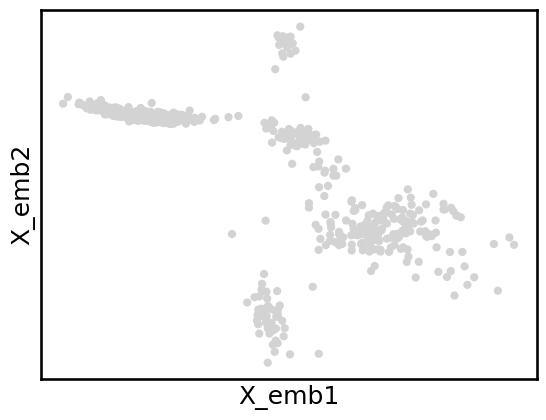

1
855 1710
[2023-05-24 01:22:23,337] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:22:23,345] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:22:23,347] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:22:23,358] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:22:23,361] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:22:23,366] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:22:23,367] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 

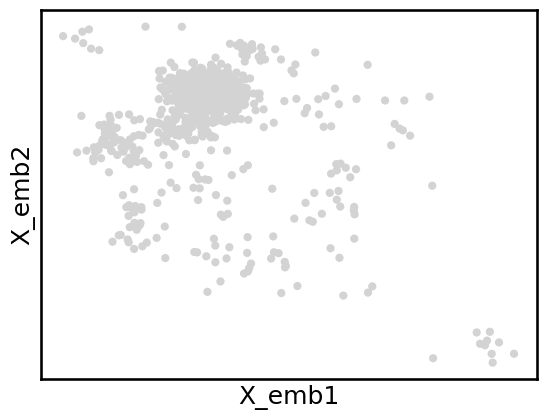

11
9405 10260
[2023-05-24 01:23:52,077] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:23:52,085] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:23:52,087] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:23:52,101] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:23:52,105] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:23:52,111] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:23:52,113] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/

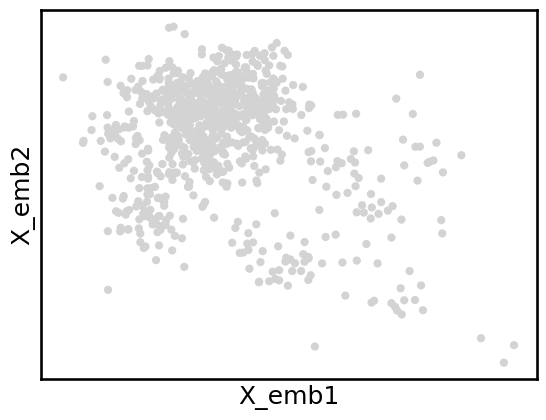

21
17955 18810
[2023-05-24 01:25:03,375] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:25:03,383] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:25:03,385] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:25:03,398] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:25:03,403] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:25:03,409] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:25:03,410] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

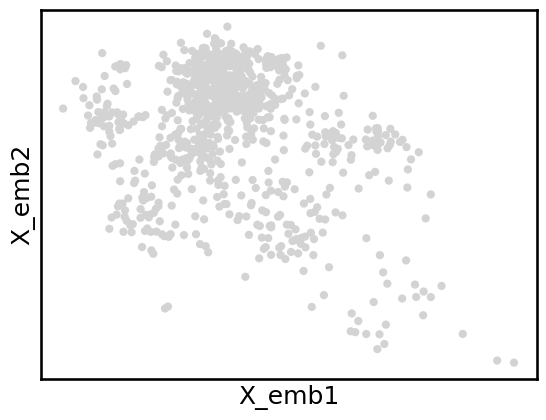

31
26505 27360
[2023-05-24 01:26:31,905] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:26:31,917] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:26:31,919] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:26:31,939] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:26:31,943] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:26:31,949] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:26:31,953] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

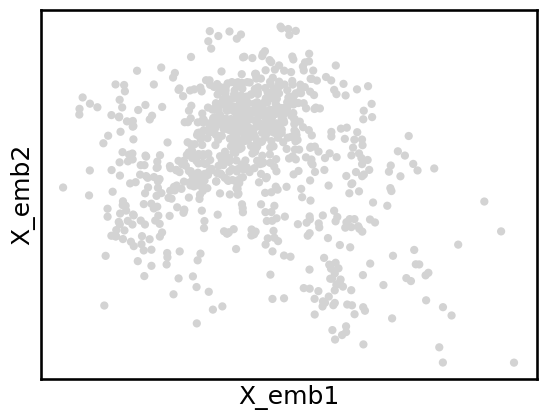

41
35055 35910
[2023-05-24 01:28:02,080] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:28:02,088] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:28:02,090] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:28:02,105] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:28:02,109] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:28:02,115] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:28:02,116] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

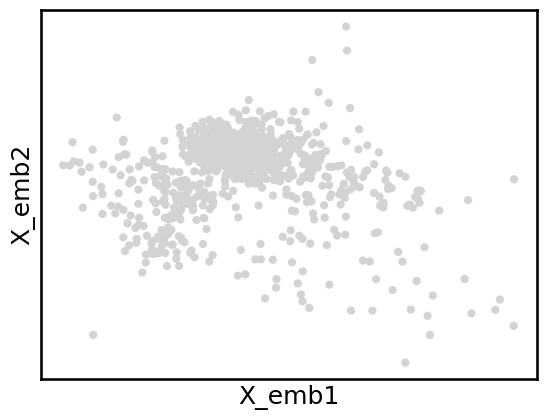

51
43605 44460
[2023-05-24 01:29:16,289] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:29:16,297] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:29:16,299] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:29:16,312] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:29:16,315] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:29:16,320] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:29:16,321] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

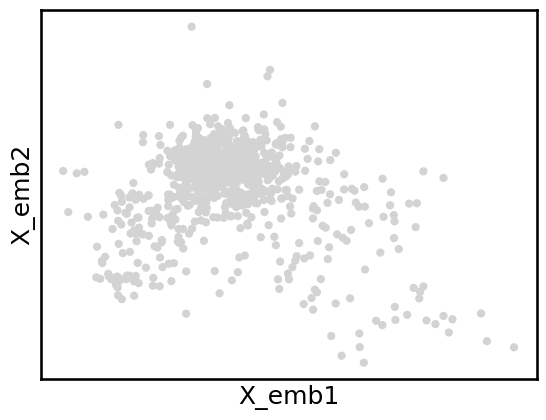

61
52155 53010
[2023-05-24 01:30:25,898] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:30:25,906] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:30:25,907] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:30:25,920] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:30:25,923] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:30:25,927] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:30:25,928] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

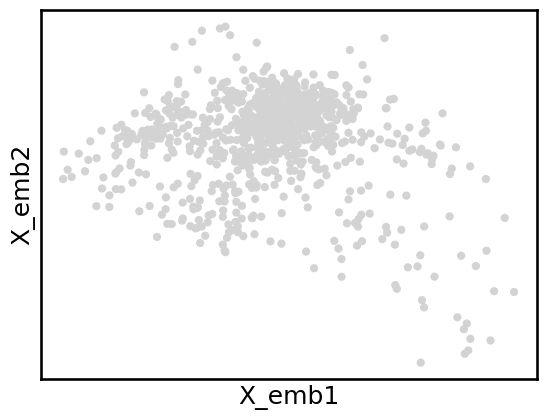

71
60705 61560
[2023-05-24 01:31:33,267] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:31:33,274] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:31:33,275] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:31:33,285] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:31:33,289] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:31:33,295] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:31:33,296] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

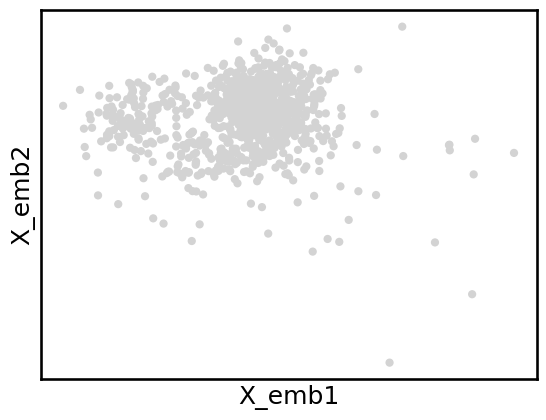

81
69255 70110
[2023-05-24 01:33:09,473] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:33:09,482] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:33:09,484] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:33:09,496] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:33:09,500] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:33:09,507] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:33:09,508] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

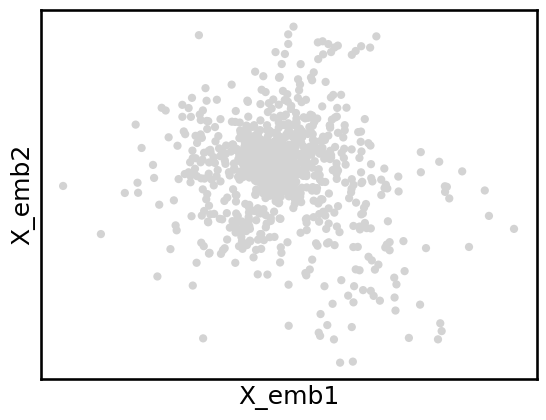

91
77805 78660
[2023-05-24 01:34:40,651] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2023-05-24 01:34:40,661] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2023-05-24 01:34:40,663] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2023-05-24 01:34:40,676] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2023-05-24 01:34:40,680] INFO - scvi.dataset.dataset | Downsampled from 855 to 855 cells
[2023-05-24 01:34:40,687] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2023-05-24 01:34:40,689] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25

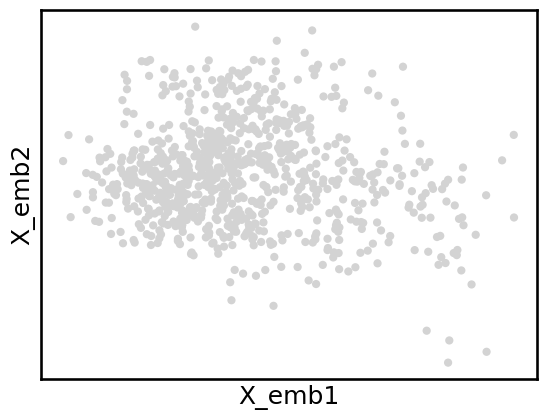

In [167]:
import pandas as pd
n_subsets = 100
log_each = 10

idx_random = pd.Series(adata.obs_names).sample(adata.shape[0], random_state=n_subsets)
n_obs_sample = int(adata.shape[0] / n_subsets)

# full dataset
vae = VAE(
    net_adataset.nb_genes,
    reconstruction_loss='nb',
    n_batch=net_adataset.n_batches,
    n_layers=n_layers,
    n_latent=n_latent,
    n_hidden=n_hidden,
)

print('sample size:', n_obs_sample)
print('# samples:', n_subsets)

for i in np.arange(n_subsets):
    print(i)

    start, end = i * n_obs_sample, (i + 1) * n_obs_sample
    print(start, end)
    adata_sample, net_adata_sample = make_sample(adata, net_adata, start, end)
    # next_idx = idx_random[i * n_obs_sample: (i + 1) * n_obs_sample].values
    # ad_sample = adata[next_idx].copy()
    # print(i, next_idx.shape, ad_sample.shape)
    # # del ad_sample
    trainer = UnsupervisedTrainer(
        vae,
        net_adata_sample,
        train_size=1.0,
        use_cuda=True,
    )
    trainer.train(n_epochs=n_epochs, lr=1e-3)
    full_sample = trainer.create_posterior(trainer.model, net_adata_sample, indices=np.arange(len(net_adata_sample)))
    latent_sample, _, _ = full_sample.sequential().get_latent()
    adata_sample.obsm['X_emb'] = latent_sample

    if (log_each is not None and i % log_each == 0) or (i + 1 == n_subsets):
        sc.pp.neighbors(adata_sample, use_rep='X_emb', method='rapids')
        sc.tl.umap(adata_sample) #  method='rapids')
        sc.pl.embedding(adata_sample, basis='X_emb')

        full = trainer.create_posterior(trainer.model, net_adataset, indices=np.arange(len(net_adataset)))
        latent, _, _ = full.sequential().get_latent()
        np.savez('latent_%i.npz' % i, latent=latent)

